<a href="https://colab.research.google.com/github/ruben9324/curso-series-temporales/blob/master/TFM_DATASCIENCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAREA #1: ENTENDER EL ENUNCIADO DEL PROBLEMA Y EL CASO PRÁCTICO

# TAREA #2: IMPORTAR LIBRERÍAS Y DATASETS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile 
import cv2 
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files 
%matplotlib inline


In [ ]:
# Montar la unidad en Google Drive: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Datos que contienen imágenes con defectos con máscara de segmentación 
defect_class_mask_df = pd.read_csv('/content/drive/My Drive/UCM_TFM/train.csv') #train.csv tiene las imágenes con la máscara.

En train.csv hay 7096 imágenes con defectos de las cuales únicas hay 6667. Esto quiere decir que hay 429 imágenes con más de 1 defecto. 
Por otro lado en el conjunto de imágenes de train (train_images) hay 12568 imágenes con y sin defectos. De esas 12568 imágenes sabemos que 429 imágenes tienen más de un defecto. 
Por tanto, el total de imágenes (considerando que una imágen con varios defectos se divide en varias imágenes; tantas como número de defectos tiene la original) es de 12568 + 429 = 12997

In [ ]:
# Datos que contienen imágenes con y sin defectos 
all_images_df = pd.read_csv('/content/drive/My Drive/UCM_TFM/defect_and_no_defect.csv')


In [ ]:
defect_class_mask_df #ClassId es el tipo de defecto. 
                     # EncodedPixels es la codificación de la máscara de la imágen.

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [ ]:
all_images_df #label: si tiene o no defecto. 

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


# Análisis exploratorio de los datos

Cada imagen puede tener más de un defecto. Vemos cúantas imágenes tienen los diferentes números de defectos. 

In [ ]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [ ]:
defect_class_mask_df.head(50)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Número de imágenes por defecto')

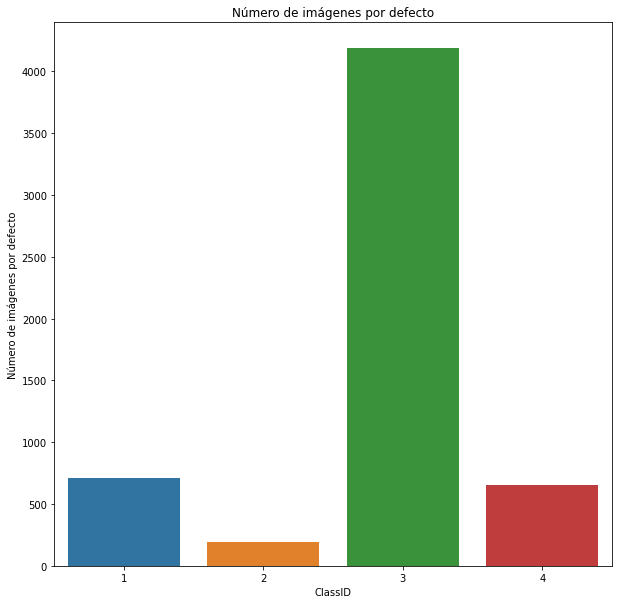

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Número de imágenes por defecto')
plt.xlabel('ClassID')
plt.title('Número de imágenes por defecto')

In [ ]:
# Algunas imágenes están clasificadas con más de un defecto, exploremos esto con más detalle
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()


In [ ]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [ ]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

Tenemos un dataset desbalanceado:
- 5201 imágenes con 1 tipo de defecto
- 272 imágenes con 2 tipos de defectos
- 1 imagen con 3 tipos de defectos

Para poder corregir esto podríamos utilizar una aumentación de datos, haciendo alguna transformación sobre las imágenes de los tipos de defectos menos representados como la rotación de las imágenes, factor de escala, modificación del brillo, etc. 

Text(0.5, 1.0, 'Número de defectos en la imagen')

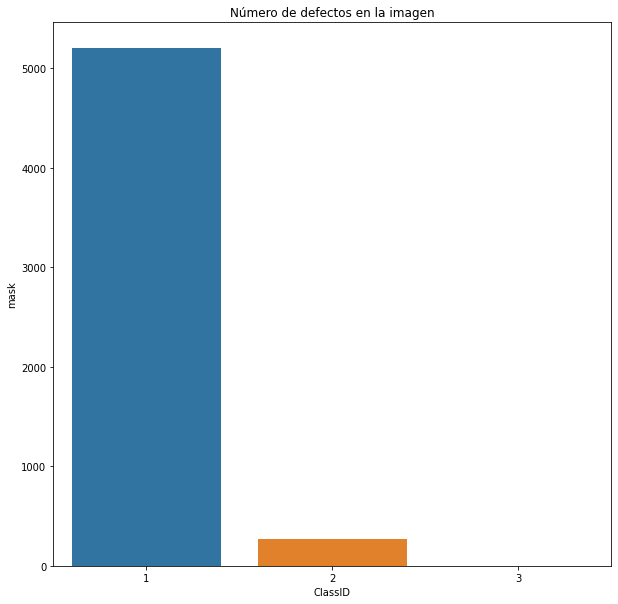

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Número de defectos en la imagen')

In [ ]:
defect_class_mask_df.shape

(5748, 4)

In [ ]:
all_images_df.shape

(12997, 2)

In [ ]:
# Contemos imágenes con y sin defectos
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

Tenemos 7095 imágenes con defecto y 5902 sin defecto. En este caso, podría considerarse como balanceado. 

Text(0.5, 1.0, 'Defect and non-defect images')

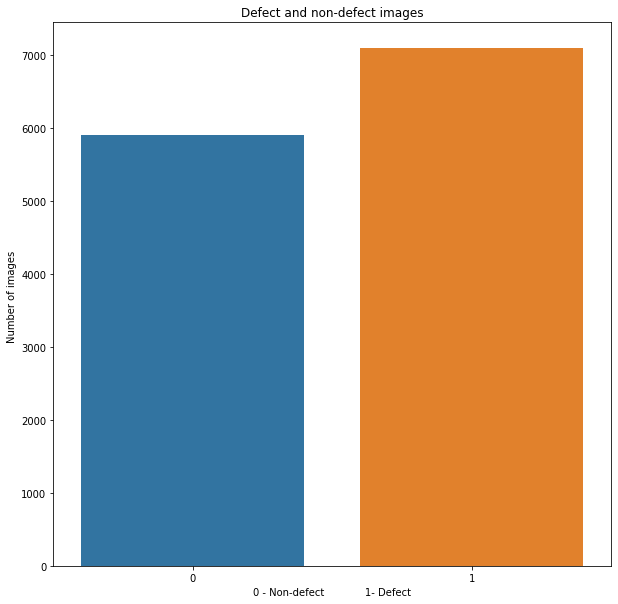

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

Para la tarea de clasificación tenemos los datos balanceados por lo que no habrá problemas en ese sentido. 

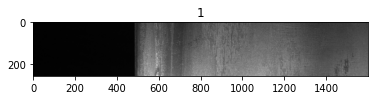

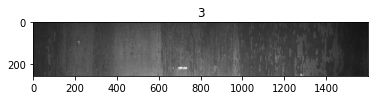

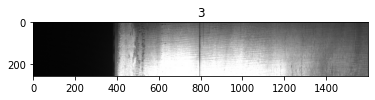

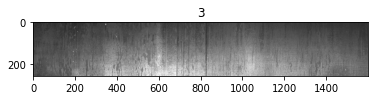

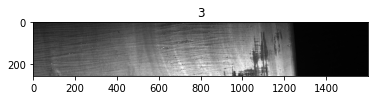

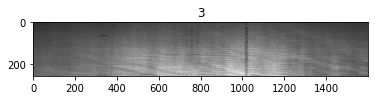

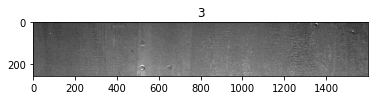

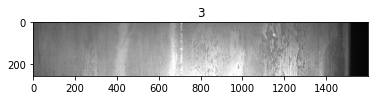

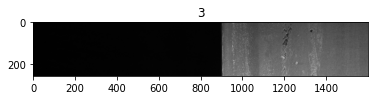

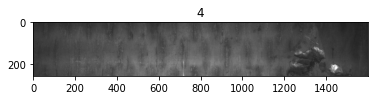

In [ ]:
# Visualizar imágenes con defectos junto con sus etiquetas correspondientes
# Las imágenes son de 256 x 1600
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/My Drive/UCM_TFM/train_images/'

for i in range(10):
  # Especificar el path de las imágenes a partir de su ID de imagen
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)


In [ ]:
# El archivo de Utilities contiene el código para rle2mask, mask2rle, función de pérdida personalizada y generador de datos personalizados
# dado que los datos proporcionados para la segmentación están en formato RLE (run length encoded), usaremos la siguiente función para convertir el RLE a máscara.
# podemos convertir la máscara nuevamente a RLE para evaluar el rendimiento del modelo (accuracy).
# El código fuente para estas funciones proviene de: 
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

# Combinar utilities con utilities2 para dejarlo en un mismo fichero.

%cd //content/drive/My Drive/UCM_TFM
from utilities3 import rle2mask , mask2rle

train_dir = '/content/drive/My Drive/UCM_TFM/train_images/'

/content/drive/My Drive/UCM_TFM


In [ ]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [ ]:
# Intentemos usar rle2mask en un imagen de prueba
image_index = 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1]) #recodifica a 0 y 1 y construye una matriz bidimensional.  
mask.shape

(256, 1600)

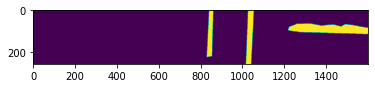

In [ ]:
# Veamos la máscara
plt.imshow(mask)

(256, 1600, 3)

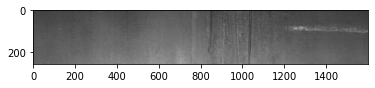

In [ ]:
# Imagen original.
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

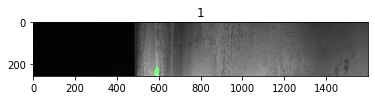

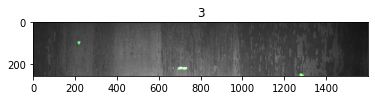

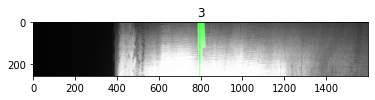

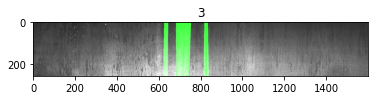

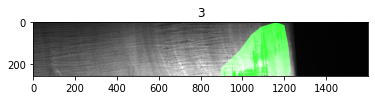

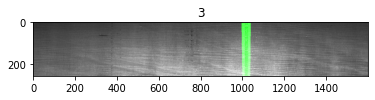

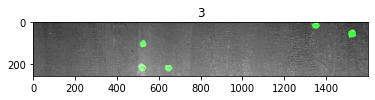

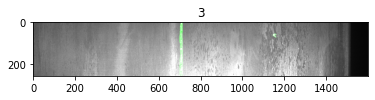

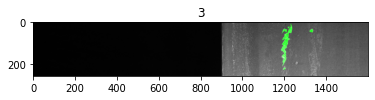

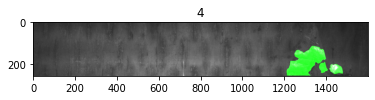

In [ ]:
for i in range(10):

  # Leer las imágenes usando opencv y convertila a formato RGB
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Máscara de la imagen con RLE
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
  
  # Pintar píxeles de valor = 1 en la máscara.
  # RGB: 0 (Rojo)
  #      1 (Verde)
  #      2 (Azul)
  img[mask == 1,1] = 255  #Cuando haya fallo se colorea de verde.
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])


# TAREA #4: ENTENDER LA TEORÍA E INTUICIÓN DETRÁS DE LAS REDES NEURONALES DE CONVOLUCIÓN, RESNETS Y APRENDIZAJE POR TRANSFERENCIA

La inteligencia artificial y el aprendizaje automático están transformando la industria de la fabricación. Las principales áreas que pueden beneficiarse son: 
- Departamento de mantenimiento
- Departamento de producción
- Departamento de cadena de suministro
Se ha demostrado que el aprendizaje profundo es superior a la detección y localización de defectos utilizando datos de imágenes que podrían mejorar significativamente la eficiencia de producción en la industria de la fabricación.

En este caso de estudio, asumiremos que trabajas
como consultor de lA / ML.

Has sido contratado por una empresa de fabricación
de acero en San Diego y se le te encomendado la tarea
de automatizar el proceso de detección y localización
de defectos encontrados en la fabricación del acero.
La detección de defectos ayudaría a mejorar la calidad
de fabricación, así como a reducir el desperdicio
debido a defectos de producción.

El equipo ha recopilado imágenes de superficies de
acero y se ha acercado ati para desarrollar un modelo
que pueda detectar y localizar defectos en tiempo real.
Se te han proporcionado 12600 imágenes que
contienen 4 tipos de defectos, junto con su ubicación
en la superficie de acero.


Metodología de aprendizaje profundo por capas para realizar la clasificación y segmentación. 

[añadir foto]

Redes neuronales convolucionales.

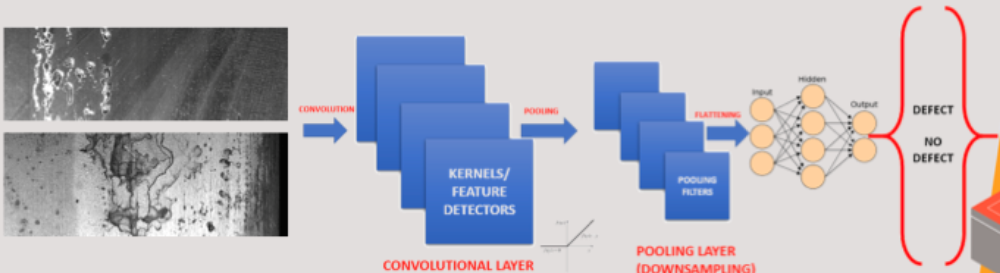

+ Las primeras capas de una RNC se utilizan para extraer
características generales de alto nivel.

+ El último par de capas se utilizan para realizar la clasificación (en una
tarea específica).

+ Los detectores de características locales escanean la imagen primero
en busca de formas simples como bordes / líneas

+ Estos bordes son luego recogidos por la capa posterior para formar
entidades más complejas.

RESNET (RED RESIDUAL) (REPASO)

+ A medida que las RNC se hacen más profundas, tienden a ocurrir gradientes
de desvanecimiento que impactan negativamente en el rendimiento de la red.

+ El problema del desvanecimiento del gradiente ocurre cuando el gradiente se
propaga hacia atrás a capas anteriores, lo que da como resultado un gradiente
muy pequeño.

+ La red neuronal residual incluye la función de "omisión de conexión" que
permite el entrenamiento de 152 capas sin sufrir los problemas de
desvanecimiento del gradiente.

+  Resnet funciona agregando "asignaciones de identidad" en la parte superior de la RNC.

+  ImagenNet contiene 11 millones de imágenes y 11.000 categorías.

*  ImageNet es el dataset utilizado para entrenar la red profunda ResNet.



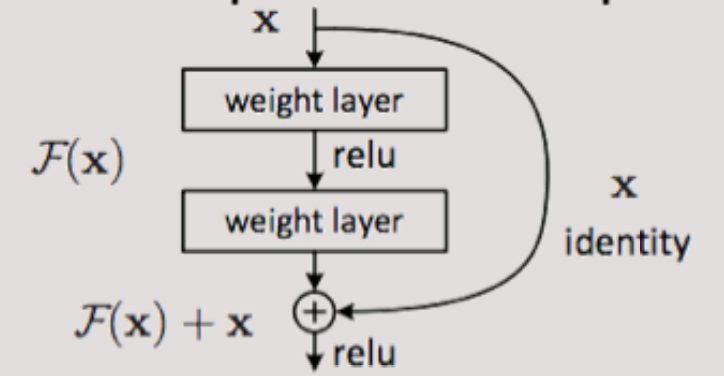

¿APRENDIZAJE POR TRANSFERENCIA? (REPASO)

+ El aprendizaje por transferencia es una técnica de aprendizaje
automático en la que una red que ha sido entrenada para realizar una
tarea específica se reutiliza como punto de partida para otra tarea similar.

+ El aprendizaje por transferencia se usa ampliamente, ya que partir de
modelos previamente entrenados se puede reducir drásticamente el
tiempo de cálculo requerido comparado con realizar el entrenamiento
desde cero.

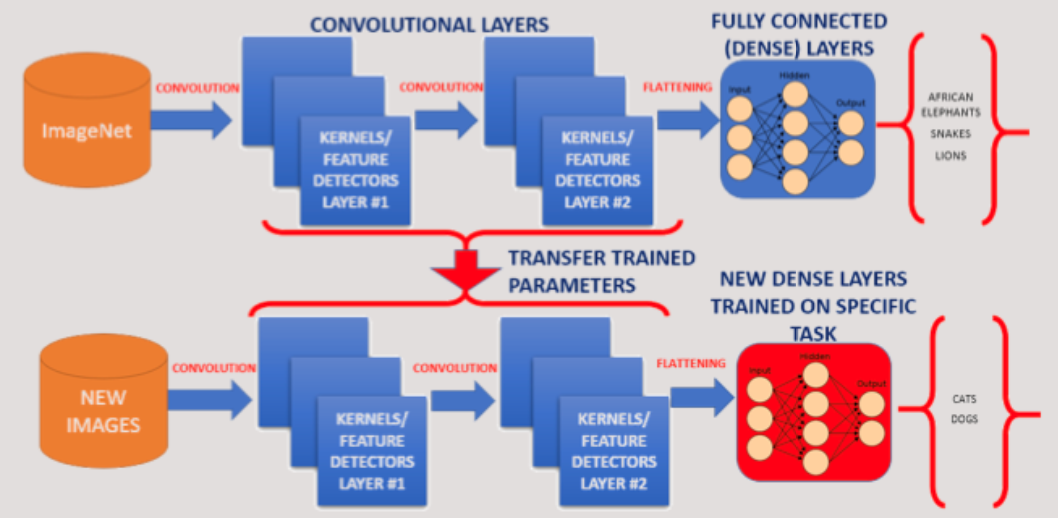

ESTRATEGIAS DE ENTRENAMIENTO EN APRENDIZAJE POR TRANSFERENCIA

Pasos de la estrategia 1:
+ Congelar los pesos de las primeras capas de la red RNC
entrenada.
+ Entrenar solo las capas densas recién agregadas al final (con
pesos inicializados aleatoriamente).

Pasos de la estrategia 2:
+ Inicializar la red de RNC con los pesos previamente
entrenados
+ Volvemos a entrenar a toda la red de RNC mientras
establecemos que la tasa de aprendizaje sea muy pequeña,
esto es fundamental para garantizar que no cambie
agresivamente los pesos ya entrenados.

Las ventajas del aprendizaje por transferencia son:
+ Proporciona un progreso de entrenamiento rápido, no tiene que
empezar desde cero utilizando pesos inicializados aleatoriamente
+ Puede utilizar un pequeño conjunto de datos de entrenamiento
para lograr buenos resultados

Vamos a usar la primera estrategia. 

¿QUÉ ES LA SEGMENTACIÓN DE IMÁGENES?

El objetivo de la segmentación de imágenes es comprender y
extraer información de las imágenes a nivel de píxel.

La segmentación de imágenes se puede utilizar para el
reconocimiento y la localización de objetos, lo que ofrece un valor
tremendo en muchas aplicaciones, como imágenes médicas, 
coches autónomos, etc.

El objetivo de la segmentación de imágenes es entrenar una red
neuronal para producir una máscara de píxeles de la imagen.

Las técnicas modernas de segmentación de imágenes se basan en
un enfoque de aprendizaje profundo que hace uso de arquitecturas £
comunes como RNC, FCN (redes de convolución total) y encoder-decoders profundos. 

Utilizaremos la arquitectura ResUNet para resolver la tarea actual.

En el caso de las redes Unet convertimos (codificamos) la imagen en un vector seguido de un muestreo ascendente (decodificamos) de nuevo en una imagen. La entrada y la salida tienen el mismo tamaño, por lo que se conserva el tamaño de la imagen. 
Las CNN clásicas generalmente se utilizan cuando se necesita clasificar la imagen completa otorgando una etiqueta de clase. 
Por otro lado ,en las Unet se realiza una calsifición a nivel de píxeles, construyendo una función de pérdida para cada píxel de la imagen de entrada. La función Softmax se aplica a cada píxel lo que hace que el problema de segmentación se convierta en un problema de clasificación a nivel de píxel de la imagen.  


RESUNET
+ La arquitectura ResUNet combina la arquitectura troncal de UNet con bloques residuales para superar los problemas del desvanecimiento del gradiente presentes en las arquitecturas profundas.
La arquitectura de Unet se basa en redes totalmente convolucionales y está modificada de manera que funcione bien en las tareas de segmentación.
Resunet consta de tres partes:
+ (1) Codificador o ruta de contratación
+ (2) Cuello de botella
+ (3) Decodificador o ruta expansiva

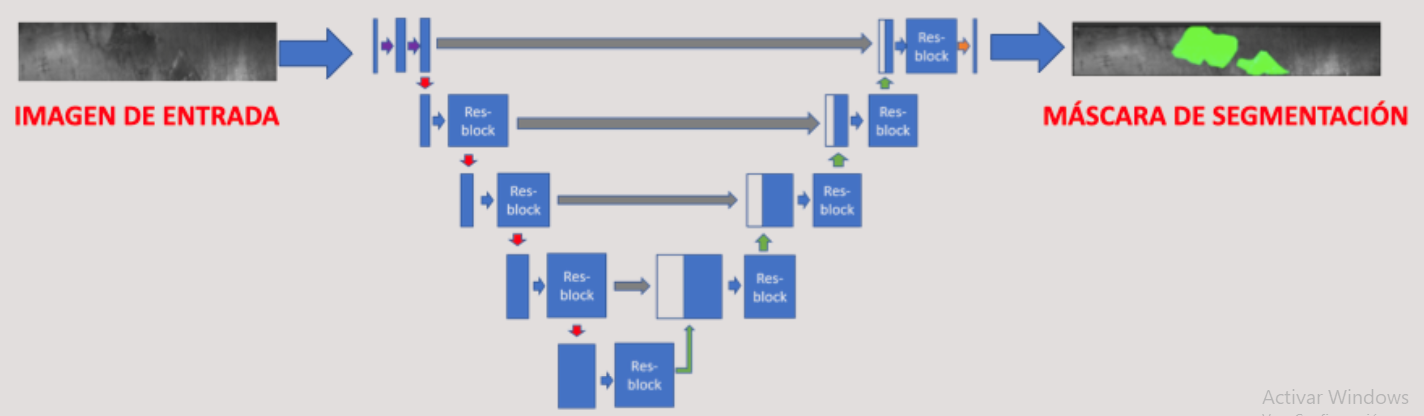

ARQUITECTURA DE RESUNET: 


Ruta de contraccción (encoder)
La ruta de contracción consta de varios bloques de contracción. Cada bloque toma una entrada que pasa  a través de res-blocks seguido de una agrupación máxima de 2x2. Los mapas de características después de cada bloque se duplican, lo que ayuda al modelo a aprender características complejas de manera efectiva. 

Cuello de botella: 
El bloque de cuello de botella sirve como conexión entre la ruta de contracción y la ruta de expansión. 
El bloque toma la entrada y luego pasa a través de un bloque res seguudo de un muestreo de capas de convolución 2x2. 

Camino de expansión (decodificador)
La ventaja significativa de esta arquitectura radica en la sección de expansión o decodificador. Cada bloque toma la entrada muestreada de la capa anterior y se concatena con las características de salida correspondientes de los bloques res en la ruta de contracción. Esto luego se pasa nuevamente a través del bloque res seguido por capas de convolución de muestreo ascendente 2x2.
Esto ayuda a garantizar que las características aprendidas durante la
contracción se utilicen al reconstruir la imagen.
Finalmente, en la última capa de la ruta de expansión, la salida del bloque res pasa a través de la capa de convolución 1x1 para producir la salida deseada con el mismo tamaño que la entrada.

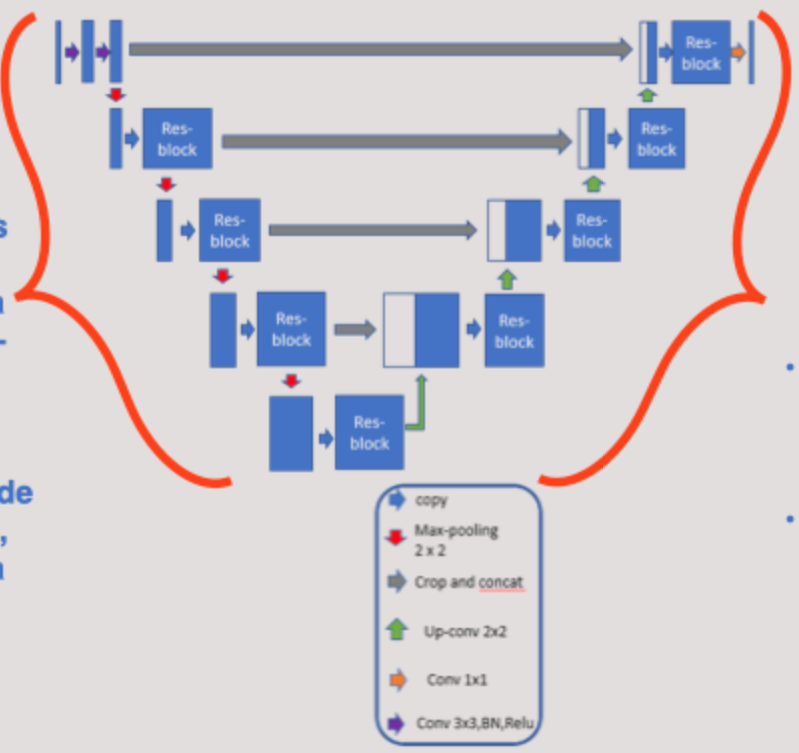

ARQUITECTURA DE RESUNET:

1. El codificador o ruta de contracción consta de 4 bloques:

+ El primer bloque consta de una capa de convolución 3x3 + Relu +
Normalización por lotes

+ Los tres bloques restantes consisten en bloques Res seguidos de
un max pooling de tamaño 2x2.

2. Cuello de botella:

+ Está entre el camino de la contracción y la expansión.

+ Consiste en un bloque Res seguido de una capa convolucional de
upsampling de tamaño 2x2.

   

3. La ruta de expansión o decodificador consta de 4 bloques: 

+ Los 3 bloques siguientes al cuello de botella consisten en
bloques de Res seguidos por una capa convolucional de
upsampling de tamaño 2 x 2

+ El bloque final consta de un Res-block seguido de una capa de
convolucional de 1x1.

MÁSCARAS:

+ El objetivo de la segmentación de imágenes es comprender la
imagen a nivel de píxel. Asocia cada píxel con una determinada
clase. La salida producida por el modelo de segmentación de
imágenes se denomina "máscara" de la imagen.

+ Las máscaras se pueden representar asociando valores de píxeles
con sus coordenadas. Por ejemplo, si tenemos una imagen negra de
forma (2,2), esta se puede representar como:



>>>>> 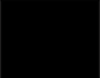



>>>>>[[0,0],
>>>>>[0,0]]

Si nuestra máscara de salida es como sigue:

>>>>> 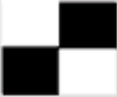


>>>>>[[255, 0],
>>>>>[0,255]]

Para representar esta máscara, primero debemos aplanar la imagen en
una matriz 1-D. Esto resultaría en una máscara temporal similar a
[255,0,0,255]. Luego, podemos usar el índice para crear la máscara para,
finalmente, obtener [1,0,0,1] como nuestra máscara debido a que los 1 y 0 ocupan menos espacio en memoria.

RUN LENGTH ENCODING (RLE):

A veces es difícil representar la máscara usando el índice, ya que
haría que la longitud de la máscara fuera igual al producto de la
altura y el ancho de la imagen.
Para superar esto, utilizamos una técnica de compresión de datos
sin pérdidas llamada codificación de longitud de ejecución (RLE),
que almacena secuencias que contienen muchos elementos de datos
consecutivos como un valor de datos único seguido del recuento.
Por ejemplo, supongamos que tenemos una imagen (una sola fila)
que contiene texto negro sin formato sobre un fondo blanco sólido.
B representa píxel negro y W representa blanco:
WWWWWWWWWWWWBWWWWWWWWW

WWWBBBWWWWWWWWWWWWWWWWW
WWWWWWWBWWWWWWWWWWWWWW

  

Run-length encoding (RLE):

12W1B12W3B24W1B14W  
Esto se puede interpretar como una secuencia de doce W, una B,
doce W, tres B, etc.

# TAREA #5: CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING PARA DETECTAR PRESENCIA O AUSENCIA DE DEFECTO EN UNA IMAGEN

In [ ]:
all_images_df

NameError: ignored

In [ ]:
# Dividir el dataset (defective and non defective)  en entrenamiento y testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

NameError: ignored

In [ ]:
train.shape

(11047, 2)

In [ ]:
test.shape

(1950, 2)

In [ ]:
train_dir = '/content/drive/My Drive/UCM_TFM/train_images/'


In [ ]:
# Crear un generador de imágenes para el conjunto de datos de entrenamiento y validación
# Dividiremos los datos en entrenamiento, validación y testing.
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# Crear un generador de datos que escale los datos de 0 a 1 (para una convergencia más rápida)y hacer una división de validación de 0,15.
# Este paso es conveniente puesto que nuestras imágenes de entrada tienen cierta resolución lo que afectaría a la memoria del ordenador. Para reducir esto el proceso de entrenamiento se hace en batches de imágenes. 
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15) 

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256)) #escalado


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


NameError: ignored

In [ ]:
# Crear un generador de datos para imágenes de test
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))



Found 1950 validated image filenames.


Máster

[MobileNetV2](https://arxiv.org/abs/1801.04381) is a significant improvement over MobileNetV1 and pushes the state of the art for mobile visual recognition including classification, object detection and semantic segmentation.

In [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) you have many pre-trained models. You can compare them [here](https://keras.io/api/applications/#available-models).

With the parameter `include_top=False`, you can delete the last `softmax` layer.

With `pretrained_model.trainable = False`, you freeze the pre-trained model weights. 

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3))) #Probar con otros datasets. 

In [ ]:
basemodel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Congelar los pesos del modelo
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)# poner max pooling.
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel) #poner hiperbólica.
headmodel = Dropout(0.3)(headmodel) #reducir problemas de overfitting.
headmodel = Dense(1, activation = 'sigmoid')(headmodel) #proceso de clasificación binario: 'sigmoid'

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:
# Usar la parada temprana para parar el entrenamiento si la pérdida en validación no baja después de un cierto número de epochs (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath="resnet-weights2.hdf5", verbose=1, save_best_only=True) #Cada vez que hagamos cambios en algo guardar los pesos del modelo.

In [ ]:
# (CUIDADO ESTO TARDA MUCHO TIEMPO (~90 mins)!) poner epochs=40
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.8094
Epoch 1: val_loss improved from inf to 2.77758, saving model to resnet-weights2.hdf5
586/586 [==============================] - 2157s 4s/step - loss: 0.4303 - accuracy: 0.8094 - val_loss: 2.7776 - val_accuracy: 0.5989
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8742
Epoch 2: val_loss improved from 2.77758 to 1.37131, saving model to resnet-weights2.hdf5
586/586 [==============================] - 120s 204ms/step - loss: 0.3147 - accuracy: 0.8742 - val_loss: 1.3713 - val_accuracy: 0.7379
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.8973
Epoch 3: val_loss did not improve from 1.37131
586/586 [==============================] - 118s 201ms/step - loss: 0.2635 - accuracy: 0.8973 - val_loss: 2.7761 - val_accuracy: 0.6632
Epoch 4/40
586/586 [==============================] - ETA: 0s - loss: 0.2332 - accuracy:

In [ ]:
# Guardamos la arquitectura del modelo entrenado para el futuro

model_json = model.to_json()
with open("resnet-classifier-model2.json","w") as json_file:
  json_file.write(model_json)

# TAREA #6: EVALUAR LA EFICACIA DEL MODELO

In [ ]:
with open('/content/drive/My Drive/UCM_TFM/resnet-classifier-model2.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargamos el modelo 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/UCM_TFM/resnet-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:
# Hacemos la predicción (CUIDADO TARDA MUCHO TIEMPO (~10 mins)!)

from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)


121/121 [==============================] - 20s 155ms/step


In [ ]:
test_predict

array([[3.0818285e-02],
       [6.7107030e-04],
       [1.3256117e-06],
       ...,
       [6.7874593e-01],
       [2.2796842e-06],
       [1.3507479e-07]], dtype=float32)

In [ ]:
# Dado que usamos la función de activación sigmoidea al final, nuestro resultado contiene valores continuos de 0 a 1.
# La red se usa inicialmente para clasificar si la imagen tiene defecto o no
# Luego, estas imágenes (defectuosas) se pasan por la red de segmentación para obtener la ubicación y el tipo de defecto.
# Vamos a elegir 0.01, para asegurarnos de que omitimos las imágenes para que no pasen por la red de segmentación a menos que
# estemos muy seguros de que no tiene ningún defecto y si no estamos seguros, podemos pasar esta imagen a través de la red de segmentación.


predict = []

for i in test_predict:
  if i < 0.01: #Por debajo del 1% de error se va considerar que no tiene error. 
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [ ]:
len(predict)

1936

In [ ]:
# como usamos el generador de prueba, limito las imágenes a 1936, debido al tamaño del lote

original = np.asarray(test.label)[:1936]
len(original)

1936

In [ ]:
# Buscamos la accuracy del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.731404958677686

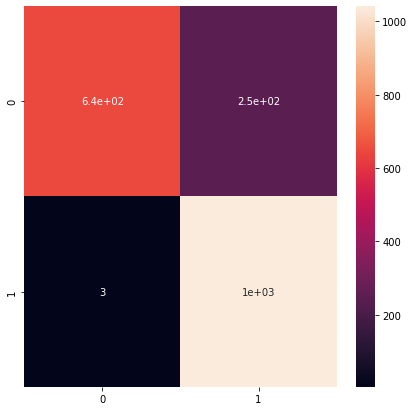

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
# Imprimimos el reporte de clasificación

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84       892
           1       0.81      1.00      0.89      1044

    accuracy                           0.87      1936
   macro avg       0.90      0.86      0.86      1936
weighted avg       0.89      0.87      0.87      1936



# TAREA #7: ENTENDER LA TEORÍA E INTUICIÓN DETRÁS DE RESUNET (SEGMENTACIÓN)

# TAREA #8: CONSTRUIR UN MODELO DE SEGMENTACIÓN CON RESUNET

In [ ]:
# dividir los datos en datos de entrenamiento y de prueba

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [ ]:
# crear una lista separada para imageId, classId y rle para pasar al generador

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [ ]:
from utilities3 import DataGenerator

# Crear el generador de imágenes

training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


In [ ]:
def resblock(X, f):
  

  # Hacemos una copia de la entrada
  X_copy = X

  # Path principal
  # Puedes leer más aquí: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Path corto
  # Puedes leer más aquí: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Añadimos el fichero de salida a partir de la combinación de path principal y el corto
  
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# Función para upscale y concatenar los valores

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5 (cuello de botella)
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


NameError: ignored

## Función de pérdidas:
 
Necesitamos una función de pérdida personalizada para entrenar a este ResUNet: https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [ ]:
%cd /content/drive/My Drive/UCM_TFM

from utilities3 import focal_tversky, tversky_loss, tversky

/content/drive/My Drive/UCM_TFM


In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# usar la parada temprana para salir del entrenamiento si la pérdida de validación no disminuye incluso después de ciertas epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# guardar el mejor modelo con menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/40
287/287 [==============================] - ETA: 0s - loss: 0.9548 - tversky: 0.0598
Epoch 1: val_loss improved from inf to 0.94554, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 1060s 4s/step - loss: 0.9548 - tversky: 0.0598 - val_loss: 0.9455 - val_tversky: 0.0719
Epoch 2/40
287/287 [==============================] - ETA: 0s - loss: 0.9121 - tversky: 0.1148
Epoch 2: val_loss improved from 0.94554 to 0.85208, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 111s 385ms/step - loss: 0.9121 - tversky: 0.1148 - val_loss: 0.8521 - val_tversky: 0.1914
Epoch 3/40
287/287 [==============================] - ETA: 0s - loss: 0.6941 - tversky: 0.3832
Epoch 3: val_loss improved from 0.85208 to 0.64756, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 114s 396ms/step - loss: 0.6941 - tversky: 0.3832 - val_loss: 0.6476 - val_tversky: 0.4387
Epoch 4/40
287/2

In [ ]:
# Guardamos el modelo para uso futuro

model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

# TAREA #9: EVALUAR LA EFICACIA DEL MODELO DE SEGMENTACIÓN ENTRENADO

In [ ]:
from utilities3 import focal_tversky, tversky_loss, tversky

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Cargar el modelo
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

ModuleNotFoundError: ignored

In [ ]:
# Datos del conjunto de test para la tarea de segmentación

test_df = pd.read_csv('test.csv')


In [ ]:
test_df

In [ ]:
test_df.ImageId

In [ ]:
from utilities3 import prediction

# Hacemos la predicción
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [ ]:
# Creamos el dataframe para el resultado
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


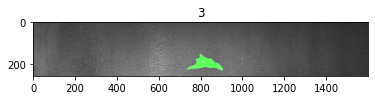

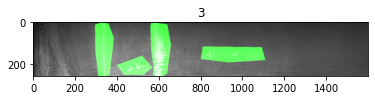

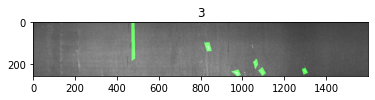

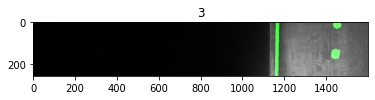

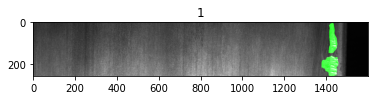

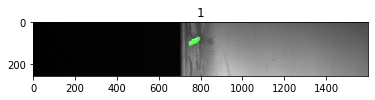

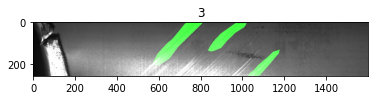

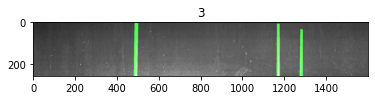

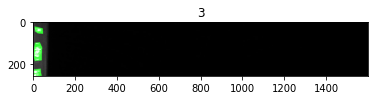

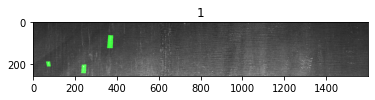

In [ ]:
# Vamos a mostrar las imágenes junto con sus máscaras originales (ground truth)
for i in range(10):

  # leer las imágenes usando opencv y convertirlas a formato rgb
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtener máscara para la imagen de rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

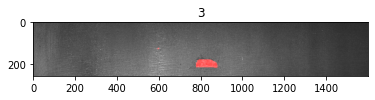

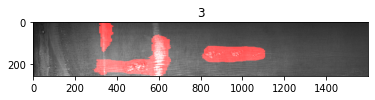

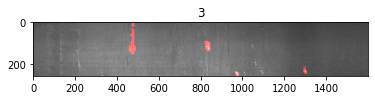

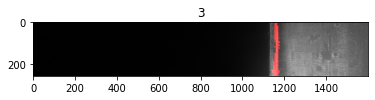

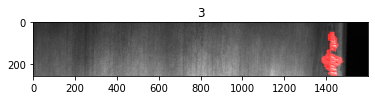

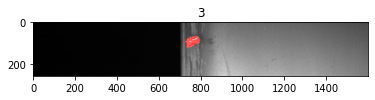

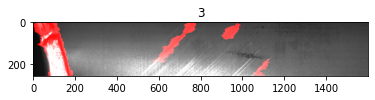

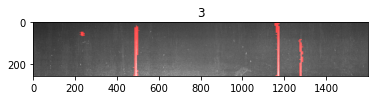

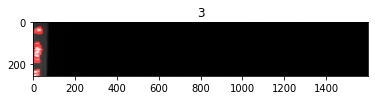

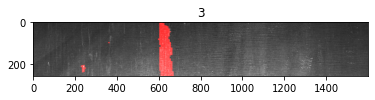

In [ ]:
# visualizar los resultados (predicciones del modelo)

directory = "train_images"

for i in range(10):

  # leer las imágenes usando opencv y convertirlas a formato rgb
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

   # Obtener máscara para la imagen de rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])
  
  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)

In [ ]:
#Para saber qué configuración tiene el modelo entrenado. 

from tensorflow.keras.utils import plot_model
plot_model(model_seg, show_shapes=True) #Para ver el dibujo del esquema.
model_seg.get_config()

NameError: ignored

# BUEN TRABAJO!!